In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pyddm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.optimize as optimize
from scipy.stats import norm
import joblib
from joblib import Parallel, delayed, parallel_backend
import multiprocessing
from multiprocessing import Value
from tqdm.auto import tqdm


In [2]:
#read the data
df_exp=pd.read_csv('./Haddara2022Expt2_clean.csv')

#data clean & new columns
df_exp=df_exp.loc[(df_exp['RT_dec'] >=0.2) & (df_exp['RT_dec'] <=2)].reset_index()
df_exp=df_exp.loc[(df_exp['RT_conf'] <=2)].reset_index()
df_exp["Correct"]=(df_exp.Stimulus==df_exp.Response)*1

df_exp.head()

lens = []
for s in df_exp.Subj_idx.unique():
    df_subj = df_exp.loc[df_exp['Subj_idx'] == s]
    lens.append(df_exp.shape[0])

## Custom loss

In [3]:
def conf_prob(C1, C2, C3, mu, sigma):
    pC1 = norm.cdf(x = C1 , loc =  mu, scale =  sigma);
    pC2 = norm.cdf(x = C2 , loc =  mu, scale =  sigma) - pC1;
    pC3 = norm.cdf(x = C3 , loc =  mu, scale =  sigma) - pC2 - pC1;
    pC4 = 1 - pC3 - pC2 - pC1;
    return [pC1, pC2, pC3, pC4]

def mynoisyloss(pp):
    #pp: 0-drift rate, 1-bound, 2-nondectime, 3-tau, 4-c1,
    
    drift_rate=pp[0];
    bo=pp[1];
    nondectime=pp[2];
    tau=pp[3];
    C1=pp[4];
    C2=C1+pp[5];
    C3=C2+pp[6];
    
    confidence_noise = pp[7]
    
    m=pyddm.Model(drift=pyddm.DriftConstant(drift=pp[0]),
            bound=pyddm.BoundConstant(B=pp[1]),
            overlay=pyddm.OverlayNonDecision(nondectime=pp[2]),
            T_dur=2,
            dt=.001/2)
    sol=m.solve()
    
    correct_pdf=sol.pdf("correct")
    error_pdf=sol.pdf("error")
    
    #the confidence part
    sigma = np.sqrt(tau) + confidence_noise
    mu = drift_rate * tau + bo #a being bound param
    correct_cdf=conf_prob(C1, C2, C3, mu, sigma)
    mu = drift_rate * tau - bo #a being bound param
    error_cdf=conf_prob(C1, C2, C3, mu, sigma)
    #end the confidence part
    
    loglike=0
    
    loglike=loglike+np.sum(np.log(1e-10+correct_pdf[(df1.loc[df1["Correct"]==1,'RT_dec']/.001).astype('int')]))
    loglike=loglike+np.sum(np.log(1e-10+error_pdf[(df1.loc[df1["Correct"]==0,'RT_dec']/.001).astype('int')]))
    
    for k in range(0,4):
        conf_sum=len(df1[(df1["Correct"]==1) & (df1["Confidence"]==(k+1))])
        loglike=loglike+np.sum(np.log(1e-10+ correct_cdf[k])*conf_sum)
    

    for k in range(0,4):
        conf_sum=len(df1[(df1["Correct"]==0) & (df1["Confidence"]==(k+1))])
        loglike=loglike+np.sum(np.log(1e-10+ error_cdf[k])*conf_sum)
        
    return -loglike

def myloss_feedback(pp):
    #pp: 0-drift rate, 1-bound, 2-nondectime, 3-tau, 4-c1,
    
    drift_rate=pp[0];
    bo=pp[1];
    nondectime=pp[2];
    tau=pp[3];
    C1=pp[4];
    C2=C1+pp[5];
    C3=C2+pp[6];
    
    confidence_noise = pp[7]
    
    m=pyddm.Model(drift=pyddm.DriftConstant(drift=pp[0]),
            bound=pyddm.BoundConstant(B=pp[1]),
            overlay=pyddm.OverlayNonDecision(nondectime=pp[2]),
            T_dur=2,
            dt=.001/2)
    sol=m.solve()
    
    correct_pdf=sol.pdf("correct")
    error_pdf=sol.pdf("error")
    
    #the confidence part
    sigma = np.sqrt(tau) + confidence_noise
    mu = drift_rate * tau + bo #a being bound param
    correct_cdf=conf_prob(C1, C2, C3, mu, sigma)
    mu = drift_rate * tau - bo #a being bound param
    error_cdf=conf_prob(C1, C2, C3, mu, sigma)
    #end the confidence part
    
    loglike=0
    
    loglike=loglike+np.sum(np.log(1e-10+correct_pdf[(df1.loc[df1["Correct"]==1,'RT_dec']/.001).astype('int')]))
    loglike=loglike+np.sum(np.log(1e-10+error_pdf[(df1.loc[df1["Correct"]==0,'RT_dec']/.001).astype('int')]))
    
    for k in range(0,4):
        conf_sum=len(df1[(df1["Correct"]==1) & (df1["Confidence"]==(k+1))])
        loglike=loglike+np.sum(np.log(1e-10+ correct_cdf[k])*conf_sum)
    

    for k in range(0,4):
        conf_sum=len(df1[(df1["Correct"]==0) & (df1["Confidence"]==(k+1))])
        loglike=loglike+np.sum(np.log(1e-10+ error_cdf[k])*conf_sum)
        
    return -loglike

def myloss_baseline_conf(pp):
    #pp: 0-drift rate, 1-bound, 2-nondectime, 3-tau, 4-c1,
    
    m=pyddm.Model(drift=pyddm.DriftConstant(drift=pp[0]),
            bound=pyddm.BoundConstant(B=pp[1]),
            overlay=pyddm.OverlayNonDecision(nondectime=pp[2]),
            T_dur=2,
            dt=.001/2)
    sol=m.solve()
    
    correct_pdf=sol.pdf("correct")
    error_pdf=sol.pdf("error")
    
    loglike=0
    loglike=loglike+np.sum(np.log(1e-10+correct_pdf[(df1.loc[df1["Correct"]==1,'RT_dec']/.001).astype('int')]))
    loglike=loglike+np.sum(np.log(1e-10+error_pdf[(df1.loc[df1["Correct"]==0,'RT_dec']/.001).astype('int')]))
    
    #strong baseline
    conf_sum=[];
    for k in range(0,4):
        conf_sum.append(len(df1[df1["Confidence"]==k+1]))
    loglike=loglike+np.sum(np.log(1e-10+conf_sum/np.sum(conf_sum))*conf_sum)

    #weak baseline
#     loglike=loglike+np.log(1e-10+0.25)*len(df1)
    
    #middle level base line
#     conf_sum=[];
#     for k in range(0,4):
#         conf_sum.append(len(df1[df1["Confidence"]==k+1]))
#     loglike=loglike+np.sum(np.log(1e-10+np.array([0.23, 0.29, 0.32, 0.16]))*conf_sum)
        
    return -loglike

## Get the result params

In [4]:
import contextlib
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [5]:
x0 = [0.50, 0.63,0.1,0.1,-2,0.1,0.1, 0.1]

bounds = [(-1, 5), (0.001, 1), (0.001,0.6),(0.001,3), (-4,4) , (0.001,4) , (0.001,4), (0.001, 3)]

def run_minimization(df_exp, subject,bounds):
    global df1
    df1 = df_exp.loc[df_exp['Subj_idx'] == subject].reset_index()

    result = optimize.differential_evolution(func=myloss, bounds=bounds)
    
    return result

subjects = df_exp.Subj_idx.unique()
all_results = []
num_cpu_cores = multiprocessing.cpu_count()
with parallel_backend('loky', n_jobs=  num_cpu_cores - 5):
    with tqdm_joblib(tqdm(total=len(subjects), desc="Participants", leave=False)) as progress_bar:
        results = Parallel()(
            (delayed(run_minimization)(df_exp, s, bounds) for s in subjects))
        
    # Combine results for all subjects
    for i in range(len(subjects)):
        all_results.append(results[i])



Participants:   0%|          | 0/60 [00:00<?, ?it/s]


KeyboardInterrupt



In [6]:
x0 = [0.50, 0.63,0.1,0.1,-2,0.1,0.1, 0.1]

bounds = [(-1, 3), (0.001, 2), (0.001,0.4),(0.001,4), (-4,4) , (0.001,4) , (0.001,4), (0.001, 3)]

def run_crossvalidation(df_exp, subject,bounds):
    global df1
    df_subj = df_exp.loc[df_exp['Subj_idx'] == subject]

    cv_train = 0;
    cv_test = 0
    for day in df_subj.Day.unique():
        # print(day)
        #training
        df1 = df_subj.loc[df_subj['Day'] != day]
        result=optimize.differential_evolution(func=mynoisyloss ,bounds=bounds)
        cv_train+= mynoisyloss(result.x)
        
        #testing
        df1 = df_subj.loc[df_subj['Day'] == day]
        cv_test+= mynoisyloss(result.x)
    
    return result, cv_train, cv_test

subjects = df_exp.Subj_idx.unique()
all_results = []
num_cpu_cores = multiprocessing.cpu_count()
with parallel_backend('loky', n_jobs=  num_cpu_cores-10):
    with tqdm_joblib(tqdm(total=len(subjects), desc="Participants", leave=False)) as progress_bar:
        results = Parallel()(
            (delayed(run_crossvalidation)(df_exp, s, bounds) for s in subjects))

    # Combine results for all subjects
    for i in range(len(subjects)):
        all_results.append(results[i])

Participants:   0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
result_params = pd.DataFrame({'ID': [], 'drift_rate':[], 'bound':[], 'non_dec':[], 'tau':[], 'CI1':[], 'CI2':[], 'CI3':[],'confidence_noise':[], 'LL':[]})

result_params.set_index('ID', inplace=True)

for s, values in enumerate(all_results):
    result, cv_train, cv_test = values
    drift, bound, non_dec, tau, CI1, CI2, CI3, confidence_noise = result.x

#    result_params.loc[s:,'ID']  = s
    result_params.loc[s,'drift_rate']  = drift
    result_params.loc[s,'bound']  = bound
    result_params.loc[s,'non_dec']  = non_dec
    result_params.loc[s,'tau']  = tau
    result_params.loc[s,'CI1']  = CI1
    result_params.loc[s,'CI2']  = CI1+ CI2
    result_params.loc[s,'CI3']  = CI2 +CI3
    result_params.loc[s,'confidence_noise']  = confidence_noise
    

    
    result_params.loc[s,'LL']  = result.fun
    AIC = 2 * len(result.x) + 2 * result.fun
    BIC = len(result.x) * np.log(len[s]) + 2 * result.fun
    result_params.loc[s,'AIC']  = AIC
    result_params.loc[s,'BIC']  = BIC
    result_params.loc[s,'cv_train']  = cv_train
    result_params.loc[s,'cv_test']  = cv_test
    
    

result_params.to_csv('./extended_pydd_params_noisy_cv.csv')

    

NameError: name 'all_results' is not defined

# Baseline Model

In [28]:
x0 = [0.50, 0.63,0.1]

bounds = [(-5, 5), (0.001, 3), (0.001,0.6)]

result_params = pd.DataFrame({'ID': [], 'drift_rate':[], 'bound':[], 'non_dec':[], 'LL':[]})

result_params.set_index('ID', inplace=True)

for s in df_exp.Subj_idx.unique():
    global df1
    df1 = df_exp.loc[df_exp['Subj_idx'] == s].reset_index()

    result_baseline = optimize.differential_evolution(func=myloss_baseline_conf ,bounds=bounds)
    drift, bound, non_dec = result.x

#    result_params.loc[s:,'ID']  = s
    result_params.loc[s,'drift_rate']  = drift
    result_params.loc[s,'bound']  = bound
    result_params.loc[s,'non_dec']  = non_dec
    
    result_params.loc[s,'LL']  = result.fun
    AIC = 2 * len(result.x) - 2 * result.fun
    BIC = len(result.x) * np.log(df1.shape[0]) - 2 * result.fun
    result_params.loc[s,'AIC']  = AIC
    result_params.loc[s,'BIC']  = BIC
    
    
result_params.to_csv('./extended_pydd_params_baseline.csv')


ValueError: too many values to unpack (expected 3)

# Visualizing models

In [45]:
lens = []
for s in df_exp.Subj_idx.unique():
    df1 = df_exp.loc[df_exp['Subj_idx'] == s].reset_index()
    lens.append(df1.shape[0])

In [47]:
model = pd.read_csv('./extended_pydd_params (1).csv').assign(len_df = lens)
base_model = pd.read_csv('./extended_pydd_params_baseline (1).csv').assign(len_df = lens)

In [61]:
model['AIC'] = 2 * 7 + 2 * model['LL']
# BIC = len(result.x) * np.log(df1.shape[0]) - 2 * result.fun
model['BIC'] = 7*np.log(model['len_df']) + 2 * model['LL']

base_model['AIC'] = 2 * 6 + 2 * base_model['LL']
# BIC = len(result.x) * np.log(df1.shape[0]) - 2 * result.fun
base_model['BIC'] = 6*np.log(base_model['len_df']) + 2 * base_model['LL']

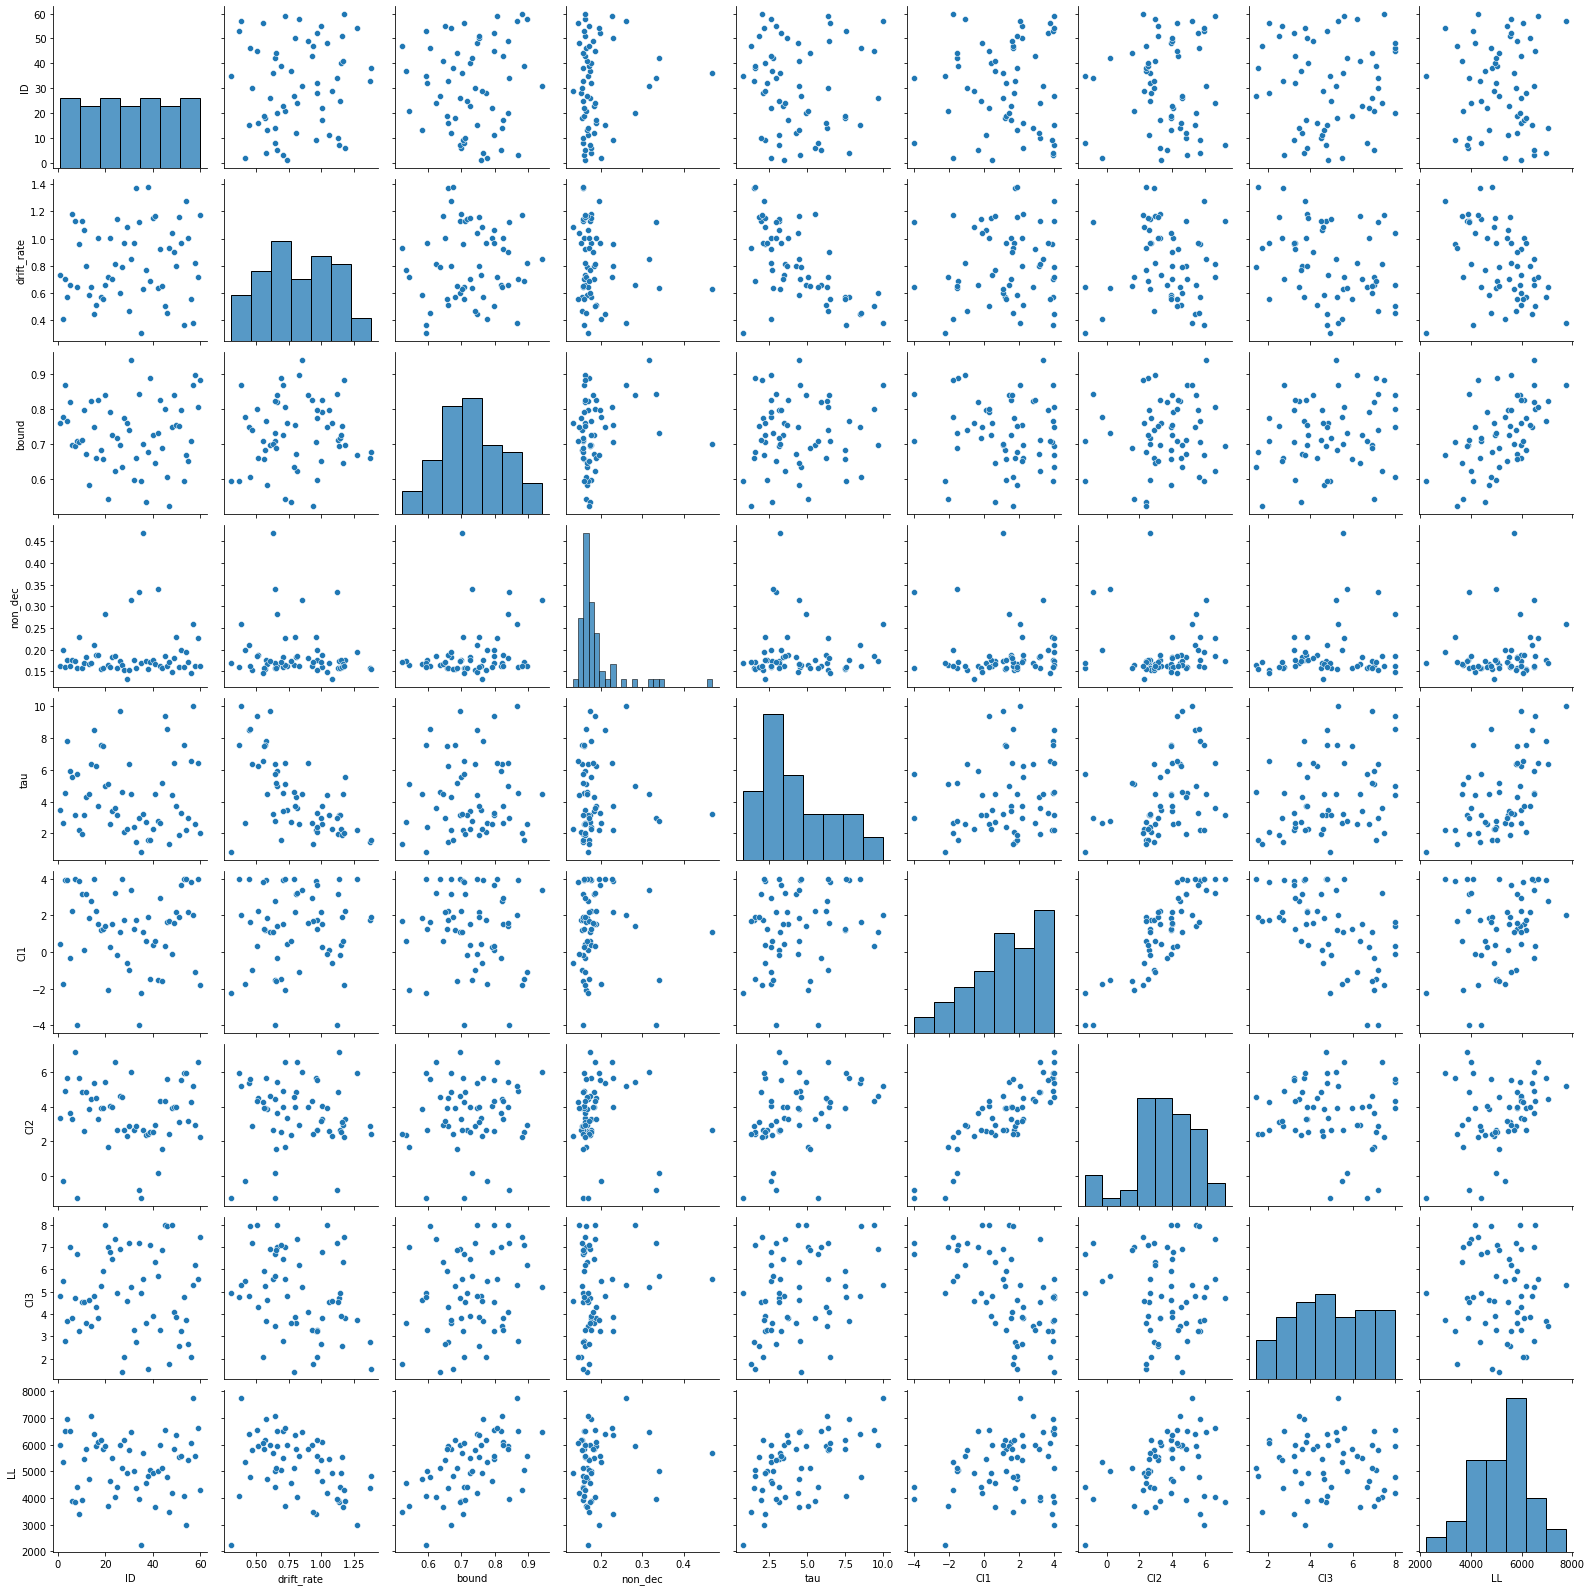

In [39]:
sb.pairplot(model)

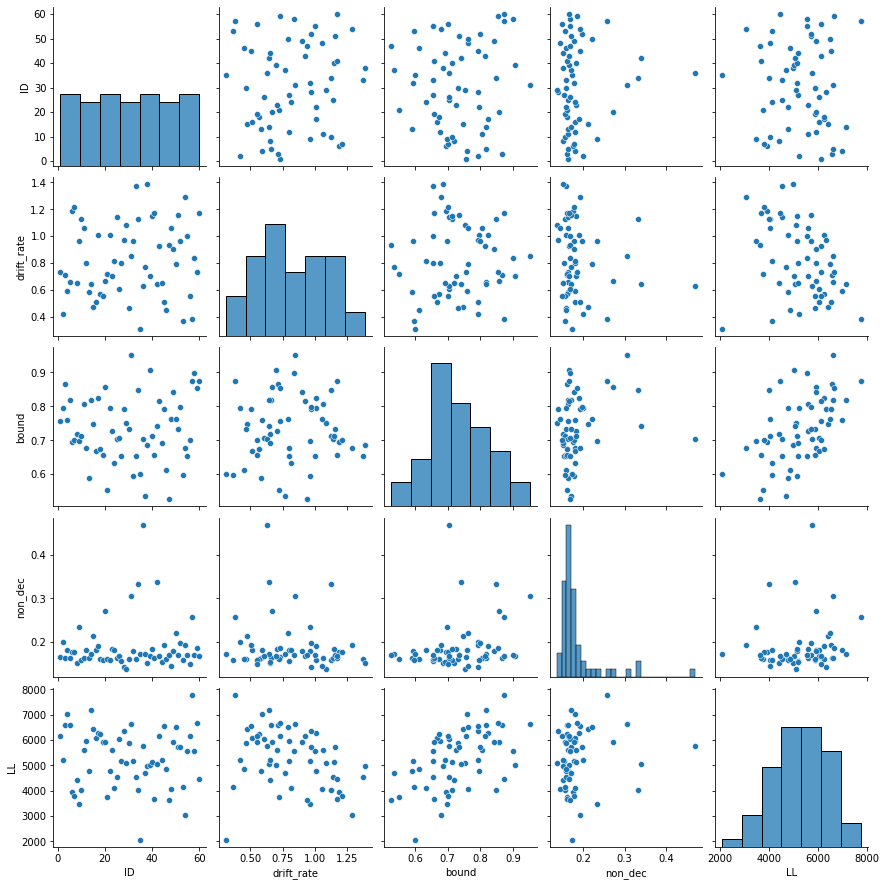

In [40]:
sb.pairplot(base_model)

/Users/nicobruno/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='BIC', ylabel='Density'>

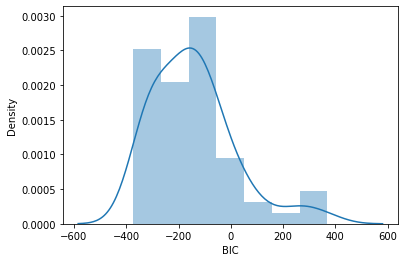

In [ ]:
sb.distplot(model.BIC - base_model.BIC)

In [64]:
np.sum(model.BIC < base_model.BIC)/(model.shape[0])

0.8666666666666667

In [ ]:
m = 
sol = m.solv

solve.pdf['correct']
solve.pdf['error']


solve.prob['correct']
...

confidence =>  data

